In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
actions = [
    'rock_paper', 
    'shaking_hands', 
    'moving_fingers', 
    'opp_rock_paper', 
    'finger_clap', 
    'rock_clap', 
    'count_number'
]

data = np.concatenate([
    np.load('dataset/seq_rock_paper_1702117736.npy'),
    np.load('dataset/seq_shaking_hands_1702117736.npy'),
    np.load('dataset/seq_moving_fingers_1702117736.npy'),
    np.load('dataset/seq_opp_rock_paper_1702117736.npy'),
    np.load('dataset/seq_finger_clap_1702117736.npy'),
    np.load('dataset/seq_rock_clap_1702117736.npy'),
    np.load('dataset/seq_count_number_1702117736.npy')
], axis=0)

data.shape

(5645, 30, 100)

In [6]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(5645, 30, 99)
(5645,)


In [7]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(5645, 7)

In [8]:
from sklearn.model_selection import train_test_split  #트레이닝셋과 테스트셋 나눔 

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5080, 30, 99) (5080, 7)
(565, 30, 99) (565, 7)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 44295 (173.03 KB)
Trainable params: 44295 (173.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
157/159 [============================>.] - ETA: 0s - loss: 13.7489 - acc: 0.3430
Epoch 1: val_acc improved from -inf to 0.35221, saving model to models/model.h5
159/159 [==============================] - 2s 9ms/step - loss: 13.6623 - acc: 0.3437 - val_loss: 8.7619 - val_acc: 0.3522 - lr: 0.0010
Epoch 2/200
 22/159 [===>..........................] - ETA: 1s - loss: 8.9567 - acc: 0.3977 

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


156/159 [============================>.] - ETA: 0s - loss: 7.7390 - acc: 0.4509
Epoch 2: val_acc did not improve from 0.35221
159/159 [==============================] - 1s 9ms/step - loss: 8.0138 - acc: 0.4476 - val_loss: 29.2618 - val_acc: 0.2354 - lr: 0.0010
Epoch 3/200
155/159 [============================>.] - ETA: 0s - loss: 16.2812 - acc: 0.3097
Epoch 3: val_acc did not improve from 0.35221
159/159 [==============================] - 1s 8ms/step - loss: 16.1413 - acc: 0.3106 - val_loss: 8.8008 - val_acc: 0.3327 - lr: 0.0010
Epoch 4/200
158/159 [============================>.] - ETA: 0s - loss: 5.2074 - acc: 0.4743
Epoch 4: val_acc improved from 0.35221 to 0.63009, saving model to models/model.h5
159/159 [==============================] - 1s 9ms/step - loss: 5.1874 - acc: 0.4758 - val_loss: 2.0091 - val_acc: 0.6301 - lr: 0.0010
Epoch 5/200
153/159 [===========================>..] - ETA: 0s - loss: 1.6862 - acc: 0.6732
Epoch 5: val_acc improved from 0.63009 to 0.67788, saving model 

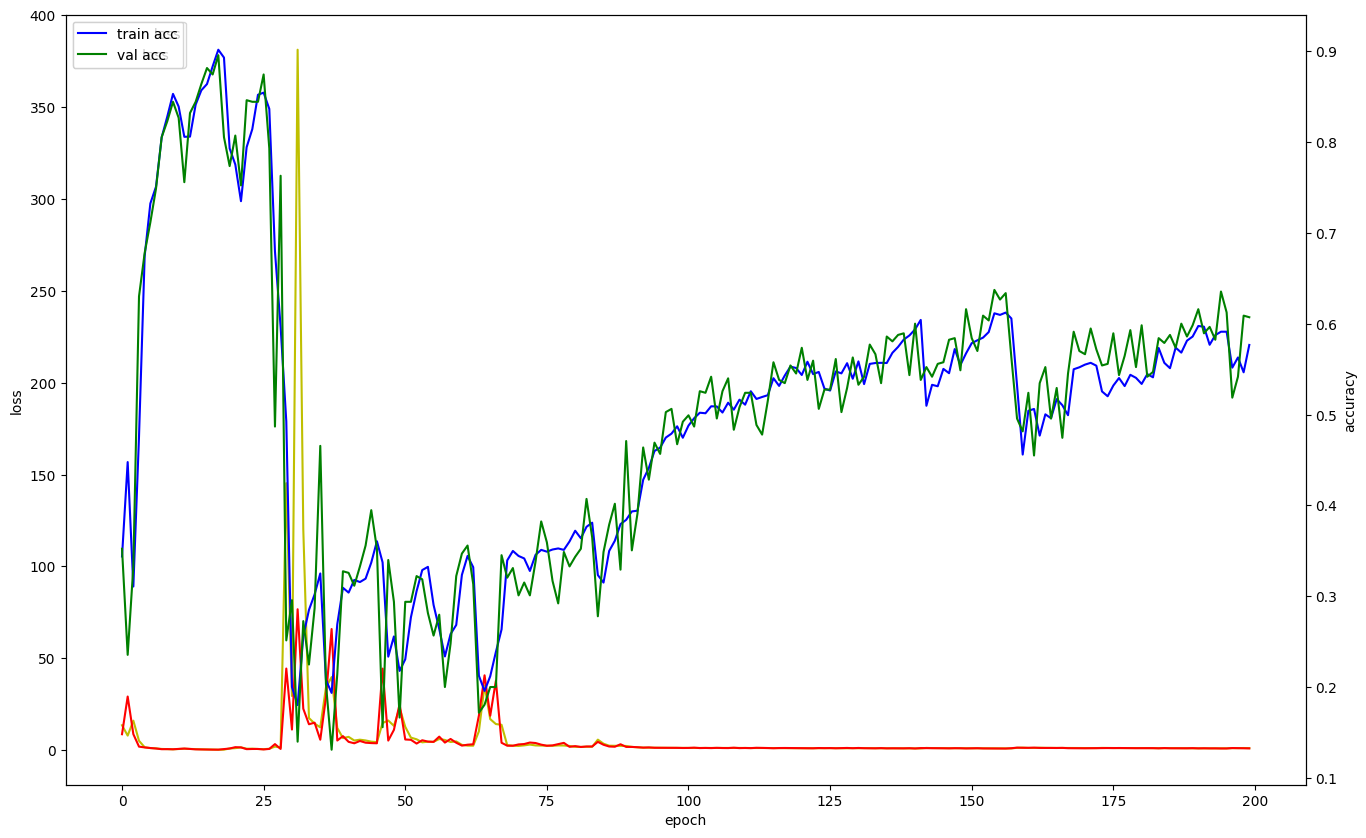

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [12]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

18/18 [==============================] - 0s 3ms/step


array([[[472,   6],
        [ 17,  70]],

       [[476,  20],
        [  9,  60]],

       [[477,  10],
        [  3,  75]],

       [[472,   3],
        [  6,  84]],

       [[470,   7],
        [ 10,  78]],

       [[495,   0],
        [  4,  66]],

       [[469,  13],
        [ 10,  73]]])